# Lab 6, unsupervised learning

## Objectives: 
1. train a Gaussian NBC with the EM algorithm (Expectation - Maximisation)
2. compare the results you get to those of the k-Means clustering provided in SciKitLearn
3. discuss the classifiers from this lab session and those from the previous session (supervised learning of NBCs) in a brief report

## Background and Tools
The EM  algorithm solves the problem of not being able to compute the Maximum Likelihood Estimates for unknown classes directly by iterating over two steps until there is no significant change in step 2 observable:

1. Compute the expected outcome for each example / sample given estimates for priors and distribution (essentially, the likelihoods for observing the sample assuming an estimated distribution).  
2. Compute new estimates for your priors and distributions (in the case of a Gaussian NBC, new means and variances are needed) based on the estimated expected values for how much each sample belongs to the respective distribution.

You can find the algorithm stated explicitly as given in Murphy, "Machine Learning - A probabilistic perspective", pp 352 - 353 http://fileadmin.cs.lth.se/cs/Education/EDAN95/Handouts/EM-algo.pdf.

One special case of the EM algorithm is k-Means clustering, for which an implementation can be found in SciKitLearn.

## Your implementation task
1. Implement the EM-algorithm to find a Gaussian NBC for the digits dataset from SciKitLearn (you can of course also use the MNIST_Light set from Lab 5, but for initial tests the digits data set is more convenient, since it is smaller in various aspects). You may assume (conditional) independence between the attributes, i.e., the covariances can be assumed to be simply the variances over each attribute. Split the data set in 70% training and 30% test data.

### Digits

<Figure size 432x288 with 0 Axes>

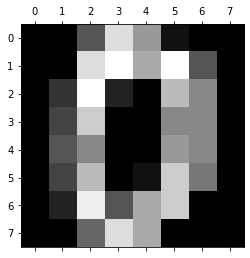

(1257, 64)

In [1]:
%matplotlib inline
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
import numpy as np
from numpy import linalg as la

digits =  load_digits()
plt.gray() 
plt.matshow(digits.images[0])
plt.show() 

split = int(len(digits.data)*0.7)

data_1_train = digits.data[:split]
data_1_test = digits.data[split+1:]
labels_1_train = digits.target[:split]
labels_1_test = digits.target[split + 1:]
np.shape(data_1_train)

### Implement the EM-algorithm

In [28]:
# Now it kinda works but we get log(0) a fair few times
import random
X = data_1_train
M = np.mean(X)
S = np.std(X)
X = (X - M) / S
K = 10
N, n_pix = np.shape(X)
# These factors are to make the systems somewhat stable. But hardky work.
sig_factor = 1         # 5e2
partial_factor = 1      # 2e1
epsilon = 1e-3            # 1e-3


# 1 initilize theta_k = (pi_k, mu_k, sigma_k)
# pi_k = prior for class k (assume uniform distr.)
# Pi = np.ones(K)/K
# log probabilities for numerical stability
Pi = np.log(np.ones(K)/K)

# mu_k = mean for class k (random subset of the data)
# sigma_k = covariance for class k (variance of data)
Mu = np.zeros([K, n_pix])
Sigma2 = np.zeros([K, n_pix])
for k in range(K):
    idx = np.random.choice(N, int(N/K))
    temp_data = X[idx]
    Mu[k,:] = np.mean(temp_data, 0)
    for p in range(n_pix):        
        Sigma2[k, p] = sig_factor * (np.mean((temp_data[:, p] - Mu[k,p]) ** 2) + epsilon)


# 2 iterate over E and M step
itr = 1
errs = 0
step_size = 10
while step_size > 1e-4:      # this will take like 60 iterations. Which is a few minutes
    # E: 
    # 2.2 where P(x_i|thetaold_k) = prod_j(exp(-(x-muold_kj)^2 / 2*sigma_kj^2) / sqrt(2*åi*sigma_kj^2))
    Post = np.ones([N, K])
    m = 0#1e6
    for n in range(N):   # To many loops but I am tired
        for k in range(K):
            for p in range(n_pix): #2e1
                # partial_post = partial_factor * np.exp(-(X[n, p]- Mu[k, p])**2 / (2 * Sigma2[k, p])) / np.sqrt(2 * np.pi * Sigma2[k, p])
                # Use log of probabilities for numerial stability
                partial_post = np.log(partial_factor * np.exp(-(X[n, p]- Mu[k, p])**2 / (2 * Sigma2[k, p])) / np.sqrt(2 * np.pi * Sigma2[k, p]))
                if partial_post < m:
                    m = partial_post
                # if np.exp(partial_post) == 0.0:
                #     errs += 1
                #     break
                # Post[n, k] *= partial_post
                Post[n, k] += partial_post
            # if errs:
            #     break
        # if errs: 
        #     break
    print('1', m)
    # print('#ERRORS: ', errs)
    # if errs:
    #     break
    #break
    # 2.1 rnew_ik = piold_k * P(x_i|thetaold_k) / (sigmaold_k * piold_k * P(x_i|thetaold_k))
    # rnew is p(class| pixel/image) 
    r = np.zeros([N, K])
    m = 0#1e6
    for n in range(N):
        r_row = np.zeros(K)
        for k in range(K):
            # r_row[k] = Post[n, k] * Pi[k]
            r_row[k] = Post[n, k] + Pi[k]
        if np.sum(r_row) < m:
            m = sum(r_row)
        # r[n, :] = r_row / sum(r_row)
        # now we dont need logs any more, b is a trick to improve numerical stability.
        # there was one more trick about removing small numbers but did not bother.
        b = np.max(r_row)
        y = np.exp(r_row - b)
        r[n, :] = y/np.sum(y)
        
    print('2', m)
    # M: 
    # rnew_k = sum_i(rnew_ik), pinew_k = rnew_k / N
    rk = sum(r, 0)
    Pi = np.log(rk / N) 
    print('min pi is: ', np.min(np.exp(Pi)))

    # munew_k = sum_i(rnew_ik*xi)/rnew_k, 
    # sigmanew_k = sum_i(rnew_ik*<xi,xi>) / rnew_k -<munew_k,munew_k> (simplified and took variance)
    Mu_new = np.zeros([K, n_pix])
    Sigma2_new = np.zeros([K, n_pix])
    for k in range(K):
        for p in range(n_pix):
            Mu_new[k, p] = np.dot(r[:,k], X[:,p]) / rk[k]
            Sigma2_new[k, p] = sig_factor * (np.dot(r[:, k], (X[:, p] - Mu[k, p]) ** 2) / rk[k] + epsilon)

    print('steps at iteration ', itr, ': ', la.norm(Mu_new - Mu), la.norm((Sigma2_new - Sigma2)/sig_factor), '\n')
    Mu = Mu_new
    Sigma2 = Sigma2_new
    # 3 stop when mu and sigma has converged
    itr += 1
    if itr > 100:
        break
np.exp(Pi)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


1 -inf
2 -inf
min pi is:  0.016544893441346756
steps at iteration  1 :  6.351857670115749 5.777228687242029 

1 -inf
2 -inf
min pi is:  0.030756220688478515
steps at iteration  2 :  4.580027429758368 6.587569281291139 

1 -inf
2 -inf
min pi is:  0.0392437742165633
steps at iteration  3 :  1.9312128287697983 2.8297667698891886 

1 -inf
2 -inf
min pi is:  0.04470333132691442
steps at iteration  4 :  1.2864638443710632 1.1720491178751462 

1 -inf
2 -inf
min pi is:  0.04763489291581358
steps at iteration  5 :  0.9296692265271161 0.8126808774846624 

1 -inf
2 -inf
min pi is:  0.04769395316644163
steps at iteration  6 :  0.6364454968666767 0.5933290417936852 

1 -inf
2 -inf
min pi is:  0.047280357222609384
steps at iteration  7 :  0.5174658439614648 0.47334609126071914 

1 -inf
2 -inf
min pi is:  0.04301047361403302
steps at iteration  8 :  0.5659770142279883 0.5294984904182751 

1 -inf
2 -inf
min pi is:  0.04002076230881171
steps at iteration  9 :  0.7491955658270364 0.8269207443463552 

1 

1 -inf
2 -inf
min pi is:  0.031179821446055286
steps at iteration  72 :  3.5314874555149485e-05 4.080950556616858e-05 

1 -inf
2 -inf
min pi is:  0.03117982708925393
steps at iteration  73 :  3.224881803465306e-05 3.7269712433922666e-05 

1 -inf
2 -inf
min pi is:  0.031179832352131804
steps at iteration  74 :  2.9476498445735025e-05 3.4068350704291454e-05 

1 -inf
2 -inf
min pi is:  0.031179837245726278
steps at iteration  75 :  2.6965436276714713e-05 3.116817120122142e-05 

1 -inf
2 -inf
min pi is:  0.031179841785369082
steps at iteration  76 :  2.468742527943176e-05 2.8536775440053144e-05 

1 -inf
2 -inf
min pi is:  0.031179845989015215
steps at iteration  77 :  2.2617862282853312e-05 2.6145870841010676e-05 

1 -inf
2 -inf
min pi is:  0.031179849876036225
steps at iteration  78 :  2.0735200140302e-05 2.397065750221741e-05 

1 -inf
2 -inf
min pi is:  0.031179853466359472
steps at iteration  79 :  1.9020497804983833e-05 2.1989320500281756e-05 

1 -inf
2 -inf
min pi is:  0.0311798567798

array([0.11935323, 0.09778803, 0.11078161, 0.08663618, 0.09943364,
       0.12340259, 0.05176626, 0.19492828, 0.03117989, 0.08473029])

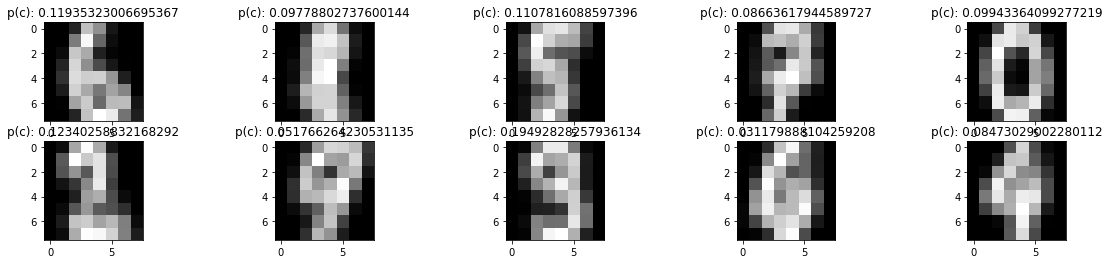

In [49]:
plt.figure(figsize=(20,4))
for k in range(K):
    plt.subplot(2, 5, k + 1)
    plt.imshow(np.reshape(Mu[k], (8,8)), cmap=plt.cm.gray)
    plt.title('p(c): {}'.format(np.exp(Pi[k]), fontsize = 15))


2. Use the result of the EM-algorithm (the found distribution parameters) to cluster the training data (essentially, using the resulting classifier to do a prediction over the training data). Produce a confusion matrix over the known labels for the training data and your EM-generated clusters. What do you see?


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Confusion matrix for my EM clasifier:
[[  0   0   0   0 123   0   0   1   0   1]
 [ 25  69   6   0   0   3   0   1   0  25]
 [  0  12   0   0   0 105   1   5   1   0]
 [  0   1   7   0   1  31   2  86   2   0]
 [  0   1   1   9   0   0  14   0  20  79]
 [  0   0  85   0   0   1   5  27   8   0]
 [121   0   1   0   0   0   0   0   5   0]
 [  0   0   1  94   0   0  29   0   0   1]
 [  1  40  34   0   0   8   0  38   1   0]
 [  3   0   5   6   1   7  14  86   2   1]]
Confusion matrix after permutating EM:
[[123   0   0   1   1   0   0   0   0   0]
 [  0  69   3   1  25   6  25   0   0   0]
 [  0  12 105   5   0   0   0   0   1   1]
 [  1   1  31  86   0   7   0   0   2   2]
 [  0   1   0   0  79   1   0   9  20  14]
 [  0   0   1  27   0  85   0   0   8   5]
 [  0   0   0   0   0   1 121   0   5   0]
 [  0   0   0   0   1   1   0  94   0  29]
 [  0  40   8  38   0  34   1   0   1   0]
 [  1   0   7  86   1   5   3   6   2  14]]


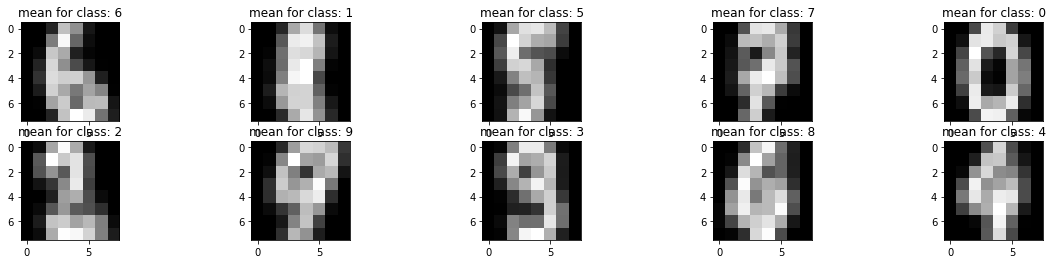

In [51]:
# Sannolikhet för xi tillhöra respektive klass
X = data_1_train
M = np.mean(X)
S = np.std(X)
X = (X - M) / S

Prob = np.zeros([N, K])
# I have this computed already for this data but should be cheep
for n in range(N):
    for k in range(K):
        for p in range(n_pix):
            partial = np.log(np.exp(-(X[n, p]- Mu[k, p])**2 / (2 * Sigma2[k, p])) / np.sqrt(2 * np.pi * Sigma2[k, p]))
            Prob[n, k] += partial

# Problem since the klasses are not sorted
y_pred = np.argmax(Prob, 1)
l = [6,1,5,7,0,2,9,3,8,4]
y_prm = np.zeros(N)
for idx, y in enumerate(y_pred):
    y_prm[idx] = l[y]
    
    
from sklearn import metrics
print("Confusion matrix for my EM clasifier:\n%s" % metrics.confusion_matrix(labels_1_train, y_pred))
print("Confusion matrix after permutating EM:\n%s" % metrics.confusion_matrix(labels_1_train, y_prm))

plt.figure(figsize=(20,4))
for k in range(K):
    plt.subplot(2, 5, k + 1)
    plt.imshow(np.reshape(Mu[k], (8,8)), cmap=plt.cm.gray)
    plt.title('mean for class: {}'.format(l[k], fontsize = 15))


3. If necessary, find a way to "repair" the cluster assignments so that you can do a prediction run over the test data, from which you can compare the results with your earlier implementation of the Gaussian NBC.

Now we get 0.59 in f1 score. Just shy of what we got with our NBC so this is better then expected considering that we trained this classifier unsupervised.

In [62]:
# Use the permutated classifier and look try this for the test data
X = data_1_test
M = np.mean(X)
S = np.std(X)
X = (X - M) / S
Nt, useless = np.shape(X)
Prob = np.zeros([Nt, K])
# I have this computed already for this data but should be cheep
for n in range(Nt):
    for k in range(K):
        for p in range(n_pix):
            partial = np.log(np.exp(-(X[n, p]- Mu[k, p])**2 / (2 * Sigma2[k, p])) / np.sqrt(2 * np.pi * Sigma2[k, p]))
            Prob[n, k] += partial

# Problem since the klasses are not sorted
y_pred = np.argmax(Prob, 1)
l = [6,1,5,7,0,2,9,3,8,4]
y_prm = np.zeros(Nt)
for idx, y in enumerate(y_pred):
    y_prm[idx] = l[y]
    
    
from sklearn import metrics
print("Classification report for my test data:\n%s\n"
    % (metrics.classification_report(labels_1_test, y_prm)))
print("Confusion matrix for my test data:\n%s" % metrics.confusion_matrix(labels_1_test, y_prm))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


Classification report for my test data:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        53
           1       0.65      0.68      0.67        53
           2       0.81      0.91      0.86        53
           3       0.28      0.60      0.38        53
           4       0.82      0.41      0.55        56
           5       0.42      0.50      0.46        56
           6       0.90      1.00      0.95        54
           7       0.81      0.81      0.81        54
           8       0.05      0.04      0.04        52
           9       0.43      0.11      0.17        55

    accuracy                           0.59       539
   macro avg       0.62      0.59      0.58       539
weighted avg       0.62      0.59      0.58       539


Confusion matrix for my test data:
[[47  0  0  0  0  0  0  0  6  0]
 [ 0 36  1  7  5  4  0  0  0  0]
 [ 0  0 48  2  0  0  3  0  0  0]
 [ 0  5  6 32  0  9  1  0  0  0]
 [ 0  0  0  0 23  1  0  7 23  2]


4. Use now also the k-Means implementation from SciKitLearn and compare the results to yours (they should be similar at least in the sense that there are classes that are more clearly separated from the rest than others for both approaches). 


In [63]:
from sklearn.cluster import KMeans
X_train = data_1_train
X_test = data_1_test
y_train = labels_1_train
y_test = labels_1_test
M = np.mean(X_train)
S = np.std(X_train)
X_train = (X_train - M) / S
M = np.mean(X_test)
S = np.std(X_test)
X_test = (X_test - M) / S
K = 10

kmeans = KMeans(n_clusters=K, max_iter=100).fit(X_train)
y_pred = kmeans.predict(X_train)
        
from sklearn import metrics
print("Classification report for my test data:\n%s\n"
    % (metrics.classification_report(y_train, y_pred)))
print("Confusion matrix for my test data:\n%s" % metrics.confusion_matrix(y_train, y_pred))

Classification report for my test data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.44      0.49      0.46       129
           2       0.02      0.02      0.02       124
           3       0.00      0.00      0.00       130
           4       0.00      0.00      0.00       124
           5       0.01      0.01      0.01       126
           6       0.97      0.98      0.97       127
           7       0.00      0.00      0.00       125
           8       0.06      0.05      0.05       122
           9       0.23      0.12      0.16       125

    accuracy                           0.17      1257
   macro avg       0.17      0.17      0.17      1257
weighted avg       0.17      0.17      0.17      1257


Confusion matrix for my test data:
[[  0   0   0 125   0   0   0   0   0   0]
 [ 25  63   0   0   0   0   2   0   0  39]
 [106  10   3   0   3   0   0   1   0   1]
 [  0   0   2   0 113   0   0  13   

In [64]:
l = [2, 8, 7, 0, 3, 4, 6, 9, 5, 1]
y_prm = np.zeros(len(y_pred))
for idx, y in enumerate(y_pred):
    y_prm[idx] = l[y]
print("Classification report for my test data:\n%s\n"
    % (metrics.classification_report(y_train, y_prm)))
print("Confusion matrix for my test data:\n%s" % metrics.confusion_matrix(y_train, y_prm))

Classification report for my test data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       125
           1       0.59      0.30      0.40       129
           2       0.80      0.85      0.82       124
           3       0.90      0.87      0.89       130
           4       0.99      0.88      0.93       124
           5       0.90      0.75      0.81       126
           6       0.97      0.98      0.97       127
           7       0.87      0.99      0.93       125
           8       0.45      0.53      0.49       122
           9       0.53      0.76      0.63       125

    accuracy                           0.79      1257
   macro avg       0.80      0.79      0.79      1257
weighted avg       0.80      0.79      0.79      1257


Confusion matrix for my test data:
[[125   0   0   0   0   0   0   0   0   0]
 [  0  39  25   0   0   0   2   0  63   0]
 [  0   1 106   3   0   0   0   3  10   1]
 [  0   0   0 113   0   2   0   2   

Classification report for my test data:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.68      0.32      0.44        53
           2       0.98      0.79      0.88        53
           3       0.77      0.77      0.77        53
           4       0.96      0.91      0.94        56
           5       0.78      0.62      0.69        56
           6       0.98      0.96      0.97        54
           7       0.85      0.96      0.90        54
           8       0.43      0.63      0.52        52
           9       0.54      0.75      0.63        55

    accuracy                           0.77       539
   macro avg       0.79      0.77      0.77       539
weighted avg       0.80      0.77      0.77       539


Confusion matrix for my test data:
[[52  0  0  0  1  0  0  0  0  0]
 [ 0 17  0  0  0  1  0  0 35  0]
 [ 1  0 42  7  0  0  0  0  0  3]
 [ 0  0  0 41  0  3  0  3  5  1]
 [ 1  1  0  0 51  1  0  2  0  0]


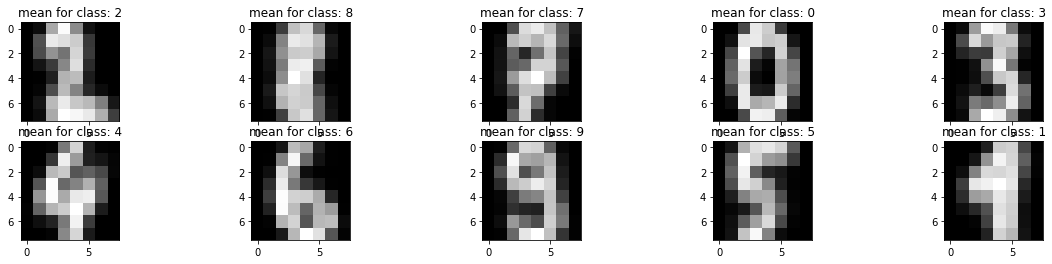

In [66]:
y_pred = kmeans.predict(X_test)

l = [2, 8, 7, 0, 3, 4, 6, 9, 5, 1]
y_prm = np.zeros(len(y_pred))
for idx, y in enumerate(y_pred):
    y_prm[idx] = l[y]
print("Classification report for my test data:\n%s\n"
    % (metrics.classification_report(y_test, y_prm)))
print("Confusion matrix for my test data:\n%s" % metrics.confusion_matrix(y_test, y_prm))

KM_mu = kmeans.cluster_centers_

plt.figure(figsize=(20,4))
for k in range(K):
    plt.subplot(2, 5, k + 1)
    plt.imshow(np.reshape(KM_mu[k], (8,8)), cmap=plt.cm.gray)
    plt.title('mean for class: {}'.format(l[k], fontsize = 15))

### Your reporting task
Write a brief (1-2 pages) report that discusses the following issues / answers the following questions. Give proper references in case you consult any material other than your implementation. 

1. In lab 5 you were asked to implement the "statistics based" NBC using counts over the encountered values for the attributes in each class. Why was that an oversimplification and how does the resulting problem relate to your first implementation of the decision tree in lab 2 for the digits data? 

2. The issue above was handled by switching to Normal distributions instead of the count based approach. Mitchell (see lecture slides lecture 10) suggests the m-estimate to solve the problem. What does the m-estimate do?

3. In lab 5 you implemented a Nearest-Centroid-Classifier (NCC) and a Gaussian NBC. How are those related?

4. Further, what is the relationship between the NCC and the result of the k-Means?

5. Explain in your own words the difference between k-Means clustering and the basic EM for GMMs as given in the Murphy-book (see above).

Submit the report in PDF-format (nothing else will be considered in this case) according to the instructions. OBS, this is Assignment 3 (report lab 6).